In [32]:
import pandas as pd
import numpy as np
#import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric, KDTree, BallTree
import pdb

In [2]:
%matplotlib inline
np.seterr(divide='raise',invalid='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
cd Geolife\ Trajectories\ 1.3

/home/me/Documents/cse523/Geolife Trajectories 1.3


In [4]:
x = pd.read_csv('Data/000/Trajectory/20081103232153.plt', skiprows=6, header=None)

In [5]:
x.head()

,0,1,2,3,4,5,6
0,39.996948,116.325747,0,492,39755.973530,2008-11-03,23:21:53
1,39.996849,116.325763,0,491,39755.973588,2008-11-03,23:21:58
2,39.994409,116.326968,0,23,39755.973646,2008-11-03,23:22:03
3,39.995076,116.326629,0,70,39755.973704,2008-11-03,23:22:08
4,39.995193,116.326572,0,75,39755.973762,2008-11-03,23:22:13


In [6]:
x.shape

(2231, 7)

In [48]:
## distance functions
def point2dist(point, line):
    linelen = np.linalg.norm(line[1]-line[0])
    if linelen==0:
        return 0
    else:
        return np.linalg.norm(np.cross(point-line[0], line[1]-line[0]))/linelen

def vertical_distance(x, y):
    if np.linalg.norm(x[1]-x[0]) < np.linalg.norm(y[1]-y[0]):
        dist_end1 = point2dist(x[0], y)
        dist_end2 = point2dist(x[1], y)
    else:
        dist_end1 = point2dist(y[0], x)
        dist_end2 = point2dist(y[1], x)
    dist = dist_end1+dist_end2
    if dist == 0:
        return 0
    else:
        return (dist_end1**2 + dist_end2**2)/dist

def parallel_distance(x, y):
    l2square = np.dot(y[1]-y[0], y[1]-y[0])
    if l2square != 0:
        l1 = np.linalg.norm(np.dot(x[0]-y[0], y[1]-y[0])/l2square*(y[1]-y[0]))
        l2 = np.linalg.norm(y[1] - y[0] - np.dot(x[1]-y[0], y[1]-y[0])/l2square*(y[1]-y[0]))
        return min(l1, l2)
    else:
        return 0

def angular_distance(x, y):
    ylen = np.linalg.norm(y[1]-y[0])
    xlen = np.linalg.norm(x[1]-x[0])
    shorter_len = min(xlen, ylen)
    longer_len = max(xlen, ylen)
    dist = np.dot(x[1]-x[0], y[1]-y[0])
    if dist < 0:
        return shorter_len
    else:
        return 0 if longer_len==0 else np.abs(np.cross(x[1]-x[0], y[1]-y[0]))/longer_len
    
def line_distance(x, y):
    return vertical_distance(x, y)+parallel_distance(x, y)+angular_distance(x, y)


In [8]:
# MDL cost
def mdl(data, model_indexes):
    """
    calculate mdl cost
    data the raw data
    model_indexes indexes into the raw data, data points choose by indexes are used to represent the raw data
    """
    # L(H) model cost could have multiple segments
    lh = 0
    for i in range(len(model_indexes)-1):
        dist = np.linalg.norm(data[model_indexes[i]]-data[model_indexes[i+1]])
        lh = lh + np.log2(dist) if dist!=0 else 0
    # L(D|H)
    ldh = 0
    # the index into the model_indexes, NOT into raw data
    model_index = 0
    for i in range(len(data)-1):
        if i > model_indexes[model_index+1]:
            model_index = model_index + 1

        model_i_start = model_indexes[model_index]
        model_i_end = model_indexes[model_index+1]
        
        if i!=model_i_start or i+1!=model_i_end:
            dist = vertical_distance((data[model_i_start], data[model_i_end]),(data[i], data[i+1]))* \
                angular_distance((data[model_i_start], data[model_i_end]), (data[i], data[i+1]))
            ldh = ldh + np.log2(dist) if dist!=0 else 0
    return lh + ldh

In [9]:
## MDL partition algorithm
def mdl_partition(path):
    partition_set = [path[0]]
    start_index = 0
    length = 1
    while start_index + length < len(path):
        curr_index = start_index + length
        # MDL cost if curr_index is included as a characteristic point
        mdlparcost=mdl(path[start_index:curr_index+1], (0, curr_index-start_index))
        # no partition, segmented line
        mdlnoparcost=mdl(path[start_index:curr_index+1], np.arange(curr_index-start_index+1))
        if mdlparcost > mdlnoparcost:
            partition_set = partition_set + [path[curr_index-1]]
            start_index = curr_index-1
            length = 1
        else:
            length = length + 1
    partition_set = partition_set + [path[len(path)-1]]
    return partition_set

In [53]:
partitions=(np.array(mdl_partition(x[[0,1]].values)))

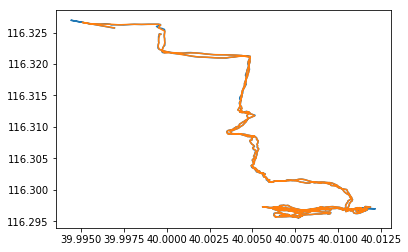

In [54]:
plt.plot(x[0], x[1])

plt.plot(partitions[:, 0], partitions[:, 1])

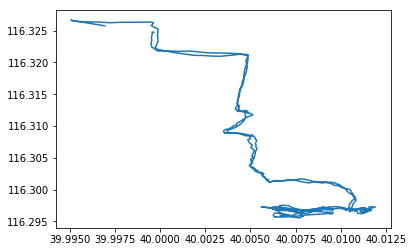

In [55]:
plt.plot(partitions[:, 0], partitions[:, 1])

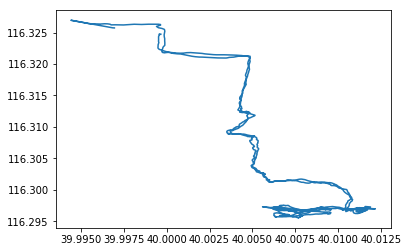

In [56]:
plt.plot(x[0], x[1])

In [57]:
partitions.shape

(713, 2)

In [23]:
segment_dist=np.zeros(len(partitions)-1)
for i in np.arange(len(partitions)-1):
    segment_dist[i] = np.linalg.norm(partitions[i] - partitions[i+1])

In [25]:
np.histogram(segment_dist)

(array([806,  94,  15,   2,   0,   0,   0,   0,   0,   1]),
 array([  1.41421356e-06,   2.83006035e-04,   5.64597856e-04,
          8.46189677e-04,   1.12778150e-03,   1.40937332e-03,
          1.69096514e-03,   1.97255696e-03,   2.25414878e-03,
          2.53574060e-03,   2.81733243e-03]))

(array([ 208.,  220.,  203.,  124.,   51.,   31.,   18.,   17.,   20.,
           8.,    7.,    3.,    4.,    0.,    1.,    1.,    0.,    0.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([  1.41421356e-06,   5.77325778e-05,   1.14050942e-04,
          1.70369306e-04,   2.26687671e-04,   2.83006035e-04,
          3.39324399e-04,   3.95642763e-04,   4.51961128e-04,
          5.08279492e-04,   5.64597856e-04,   6.20916220e-04,
          6.77234585e-04,   7.33552949e-04,   7.89871313e-04,
          8.46189677e-04,   9.02508042e-04,   9.58826406e-04,
          1.01514477e-03,   1.07146313e-03,   1.12778150e-03,
          1.18409986e-03,   1.24041823e-03,   1.29673659e-03,
          1.35305496e-03,   1.40937332e-03,   1.46569168e-03,
          1.52201005e-03,   1.57832841e-03

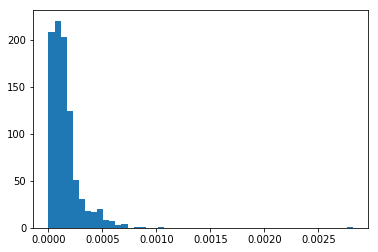

In [29]:
plt.hist(segment_dist, bins=50)

In [ ]:
def segment_clustering(segments, eps, minlines):
    """
    cluster line segment
    segments: line segments to be clustered
    eps: eps-neighbour
    minlines: threshold, mimimum number of lines
    """

In [24]:
NUM_INDEX = 2
indexed_segment = np.hstack((partitions[:-1], partitions[1:], -np.ones((len(partitions)-1, NUM_INDEX))))

In [51]:
def segment_line_dist(x, y):
    #pdb.set_trace()
    x = x[:-NUM_INDEX]
    y = y[:-NUM_INDEX]
    dimension = len(x)/2
    return line_distance((x[:dimension], x[dimension:]), (y[:dimension], y[dimension:]))

In [52]:
segment_line_dist(indexed_segment[0],indexed_segment[1]), segment_line_dist(indexed_segment[1],indexed_segment[0])

(0.0021627431152030502, 0.0021623623812594061)

In [28]:
indexed_segment[:10]

array([[  39.996948,  116.325747,   39.994409,  116.326968,   -1.      ,
          -1.      ],
       [  39.994409,  116.326968,   39.995358,  116.32648 ,   -1.      ,
          -1.      ],
       [  39.995358,  116.32648 ,   39.995647,  116.326402,   -1.      ,
          -1.      ],
       [  39.995647,  116.326402,   39.996123,  116.326359,   -1.      ,
          -1.      ],
       [  39.996123,  116.326359,   39.996555,  116.326393,   -1.      ,
          -1.      ],
       [  39.996555,  116.326393,   39.996761,  116.326232,   -1.      ,
          -1.      ],
       [  39.996761,  116.326232,   39.997479,  116.326218,   -1.      ,
          -1.      ],
       [  39.997479,  116.326218,   39.998103,  116.326331,   -1.      ,
          -1.      ],
       [  39.998103,  116.326331,   39.998533,  116.326294,   -1.      ,
          -1.      ],
       [  39.998533,  116.326294,   39.998948,  116.326337,   -1.      ,
          -1.      ]])

In [38]:
tree = BallTree(indexed_segment,leaf_size=10,  metric=segment_line_dist)

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

In [31]:
%debug

> /usr/lib/python2.7/dist-packages/numpy/core/numeric.py(1769)cross()
   1767            "(dimension must be 2 or 3)")
   1768     if a.shape[-1] not in (2, 3) or b.shape[-1] not in (2, 3):
-> 1769         raise ValueError(msg)
   1770 
   1771     # Create the output array

ipdb> u
> <ipython-input-7-95cf23ae468c>(7)point2dist()
      5         return 0
      6     else:
----> 7         return np.linalg.norm(np.cross(point-line[0], line[1]-line[0]))/linelen
      8 
      9 def vertical_distance(x, y):

ipdb> u
> <ipython-input-7-95cf23ae468c>(10)vertical_distance()
      8 
      9 def vertical_distance(x, y):
---> 10     dist_end1 = point2dist(x[0], y)
     11     dist_end2 = point2dist(x[1], y)
     12     dist = dist_end1+dist_end2

ipdb> u
> <ipython-input-7-95cf23ae468c>(37)line_distance()
     33     else:
     34         return 0 if ylen==0 else np.abs(np.cross(x[1]-x[0], y[1]-y[0]))/ylen
     35 
     36 def line_distance(x, y):
---> 37     return vertical_distance(x, y)+para

In [73]:
xx2.reshape((xx2.shape[0], 1))

array([[( 39.996948,  116.325747,  39.994409,  116.326968, -1, -1)],
       [( 39.994409,  116.326968,  39.995358,  116.32648 , -1, -1)],
       [( 39.995358,  116.32648 ,  39.995647,  116.326402, -1, -1)],
       [( 39.995647,  116.326402,  39.996123,  116.326359, -1, -1)],
       [( 39.996123,  116.326359,  39.996555,  116.326393, -1, -1)],
       [( 39.996555,  116.326393,  39.996761,  116.326232, -1, -1)],
       [( 39.996761,  116.326232,  39.997479,  116.326218, -1, -1)],
       [( 39.997479,  116.326218,  39.998103,  116.326331, -1, -1)],
       [( 39.998103,  116.326331,  39.998533,  116.326294, -1, -1)],
       [( 39.998533,  116.326294,  39.998948,  116.326337, -1, -1)],
       [( 39.998948,  116.326337,  39.999521,  116.326333, -1, -1)],
       [( 39.999521,  116.326333,  39.999646,  116.326202, -1, -1)],
       [( 39.999646,  116.326202,  39.999516,  116.325777, -1, -1)],
       [( 39.999516,  116.325777,  39.999869,  116.325509, -1, -1)],
       [( 39.999869,  116.325509, 